Author: *Davide Cittaro*   
First compiled: *February 9, 2018.*

## Cell-Cycle Scoring and Regression

This is a _Scanpy_ demo that shows how to regress cell cycle effect, following the approach showed in [Seurat's vignette](http://satijalab.org/seurat/cell_cycle_vignette.html#assign-cell-cycle-scores). As for the R example, toy dataset consists of murine hematopoietic progenitors from [Nestorowa et al., Blood 2016](https://doi.org/10.1182/blood-2016-05-716480). The files of the Seurat tutorial - used here for reasons of benchmarking - can be downloaded [here](https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1). A more recent version of the dataset can be downloaded [here](http://blood.stemcells.cam.ac.uk/data/nestorowa_corrected_log2_transformed_counts.txt.gz).

In [1]:
import h5py
import numpy as np
import pandas as pd

/cluster/work/bewi/members/tuncel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import scanpy.api as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 1.0.3 on 2018-04-23 13:55.
Dependencies: anndata==0.5.8 numpy==1.14.0 scipy==0.19.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 


Load data

In [3]:
input_file = '/cluster/home/mtuncel/sc-pipe/intermediate_files/raw_melanomaS2.h5'
h5f = h5py.File(input_file, 'r')

In [4]:
matrix = h5f['matrix'][:]
barcodes = h5f['cell_attrs']['cell_names'].value
gene_ids = h5f['gene_attrs']['gene_ids'].value
gene_names = h5f['gene_attrs']['gene_names'].value
decoder = np.vectorize(lambda t: t.decode('UTF-8'))
barcodes = decoder(barcodes)
gene_ids = decoder(gene_ids)
gene_names = decoder(gene_names)

In [5]:
matrix.shape

(2216, 19928)

In [6]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
type(gene_names)

numpy.ndarray

In [8]:
adata = sc.AnnData(X=matrix, var=gene_names)

In [9]:
adata.X.shape

(2216, 19928)

In [10]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Load cell cycle genes defined in [Tirosh et al, 2015](https://doi.org/10.1126/science.aad0501). It is a list of 97 genes, represented by their gene symbol. The list here is for humans, in case of alternate organism, a list of ortologues should be compiled.
There are major differences in the way _Scanpy_ and _Seurat_ manage data, in particular we need to filter out cell cycle genes that are not present in our dataset to avoid errors.

In [11]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]

Here we define two lists, genes associated to the S phase and genes associated to the G2M phase

In [12]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var[0].values]

In [13]:
# this is needed otherwise scanpy cannot tell the index
adata.var_names = gene_names

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


!! Standard filters applied. Note that we do not extract variable genes and work on the whole dataset, instead. This is because, for this demo, almost 70 cell cycle genes would not be scored as variable. Cell cycle scoring on ~20 genes is ineffective. 

In [14]:
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [15]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Log-transformation of data and scaling should always be performed before scoring

In [16]:
adata.X.max()

8.190857

We here perform cell cycle scoring. The function is actually a wrapper to `sc.tl.score_gene_list`, which is launched twice, to score separately S and G2M phases. Both `sc.tl.score_gene_list` and `sc.tl.score_cell_cycle_genes` are a port from _Seurat_ and are supposed to work in a very similar way. 
To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list.
Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [17]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:41.26) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:38.13) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


In [18]:
np.array(adata.obs['phase'].values)

array(['G1', 'G2M', 'G1', ..., 'G1', 'G1', 'G1'], dtype=object)

Here comes another difference from _Seurat_. The R package stores raw data, scaled data and variable genes information in separate slots, _Scanpy_ instead keeps only one snapshot of the data. This implies that PCA is always calculated on the entire dataset. In order to calculate PCA reduction using only a subset of genes (like `cell_cycle_genes`), a trick should be used.
Basically we create a dummy object to store information of PCA projection, which is then reincorporated into original dataset.

In [19]:
adata.obs['phase'].values

array(['G1', 'G2M', 'G1', ..., 'G1', 'G1', 'G1'], dtype=object)

... storing 'phase' as categorical


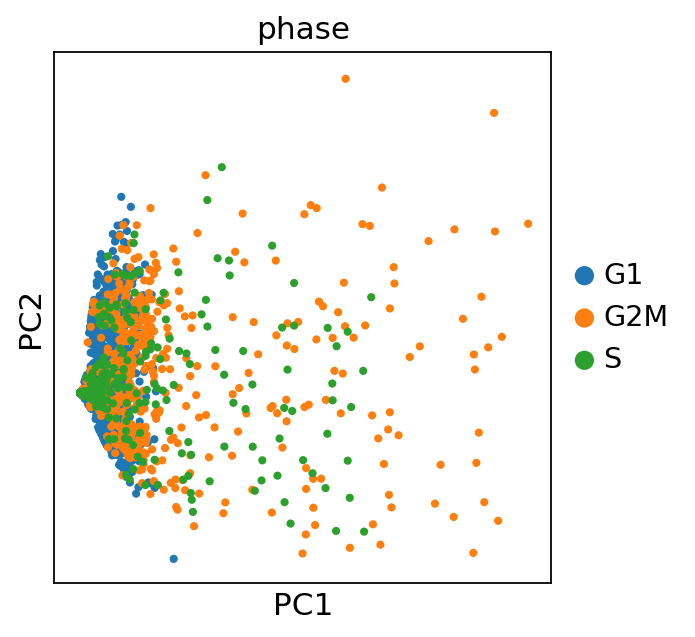

In [20]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

As in the original vignette, cells can be easily separated by their cell cycle status when cell cycle genes are used.
Now we can regress out both S score and G2M score.

In [21]:
# summary
df_before = pd.DataFrame(adata.X)

In [22]:
df_before.describe()

,0,1,2,3,4,5,6,7,8,9,...,19918,19919,19920,19921,19922,19923,19924,19925,19926,19927
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,0.000238,0.000996,0.034399,0.001155,0.000148,0.002539,0.001723,0.001708,0.000259,0.006478,...,0.000310,0.012942,0.000860,0.009512,0.067939,0.002496,0.001264,0.005824,0.027223,0.000124
std,0.008022,0.026325,0.137346,0.028280,0.006955,0.038500,0.030962,0.032690,0.009478,0.062643,...,0.010329,0.090148,0.021254,0.076910,0.209707,0.046471,0.025177,0.062189,0.128343,0.005826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.308730,0.929444,1.410497,0.923673,0.327416,0.752090,0.757376,0.885321,0.418546,0.902461,...,0.364821,0.948695,0.721218,0.940811,1.414047,1.274222,0.638295,0.928044,0.963164,0.274247


In [23]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

regressing out ['S_score', 'G2M_score']


/cluster/work/bewi/members/tuncel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


    finished (0:01:17.54)


In [24]:
# summary
df_after = pd.DataFrame(adata.X)

In [25]:
df_after.describe()

,0,1,2,3,4,5,6,7,8,9,...,19918,19919,19920,19921,19922,19923,19924,19925,19926,19927
count,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,...,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03
mean,-4.843634e-11,1.577333e-10,7.766625e-10,4.084518e-10,6.818255e-11,7.838071e-11,7.176143e-11,-2.230068e-10,5.699938e-11,-4.625093e-10,...,8.218943e-11,-1.273424e-10,1.044376e-10,7.216069e-10,-1.445735e-09,-1.324382e-10,-2.411835e-10,1.647466e-10,-1.550803e-09,5.443599e-11
std,8.020986e-03,2.632525e-02,1.371366e-01,2.827694e-02,6.954811e-03,3.848512e-02,3.095971e-02,3.266462e-02,9.477196e-03,6.255352e-02,...,1.032484e-02,9.010969e-02,2.124685e-02,7.687804e-02,2.096874e-01,4.641122e-02,2.516918e-02,6.216614e-02,1.282764e-01,5.824029e-03
min,-7.046417e-04,-1.455805e-03,-4.598073e-02,-1.808354e-03,-5.395646e-04,-1.153345e-02,-2.276603e-03,-1.646857e-02,-4.549450e-04,-3.940193e-02,...,-1.146030e-03,-1.607781e-02,-5.473176e-03,-2.779196e-02,-9.035235e-02,-1.901421e-02,-2.203591e-03,-2.296099e-02,-6.581496e-02,-1.288705e-03
25%,-2.987899e-04,-1.011506e-03,-3.785525e-02,-1.362111e-03,-1.764408e-04,-2.840396e-03,-1.899436e-03,-1.919222e-03,-3.229117e-04,-6.521125e-03,...,-4.640983e-04,-1.395200e-02,-1.098364e-03,-1.017360e-02,-6.874613e-02,-2.584739e-03,-1.561043e-03,-6.402393e-03,-2.715479e-02,-1.707985e-04
50%,-2.586066e-04,-9.874499e-04,-3.536031e-02,-1.253042e-03,-1.549497e-04,-2.366681e-03,-1.813363e-03,-1.531005e-03,-2.834956e-04,-5.813474e-03,...,-3.657091e-04,-1.339975e-02,-8.939451e-04,-9.236762e-03,-6.750552e-02,-1.953426e-03,-1.401554e-03,-5.786800e-03,-2.626236e-02,-1.102547e-04
75%,-2.049934e-04,-9.686432e-04,-3.204548e-02,-1.117993e-03,-1.278560e-04,-1.997560e-03,-1.708613e-03,-1.231897e-03,-2.329849e-04,-5.107760e-03,...,-2.358606e-04,-1.278150e-02,-6.775490e-04,-8.409141e-03,-6.620825e-02,-1.422039e-03,-1.185797e-03,-5.210985e-03,-2.535474e-02,-5.746055e-05
max,3.084014e-01,9.284279e-01,1.376454e+00,9.223922e-01,3.272233e-01,7.488032e-01,7.556067e-01,8.820970e-01,4.182019e-01,8.969318e-01,...,3.642443e-01,9.354804e-01,7.196143e-01,9.318554e-01,1.343885e+00,1.270992e+00,6.368873e-01,9.227356e-01,9.359611e-01,2.739548e-01


Finally, we reproject dataset using cell cycle genes again. Since we regressed the scores, no effect of cell cycle is now evident.

... storing 'phase' as categorical


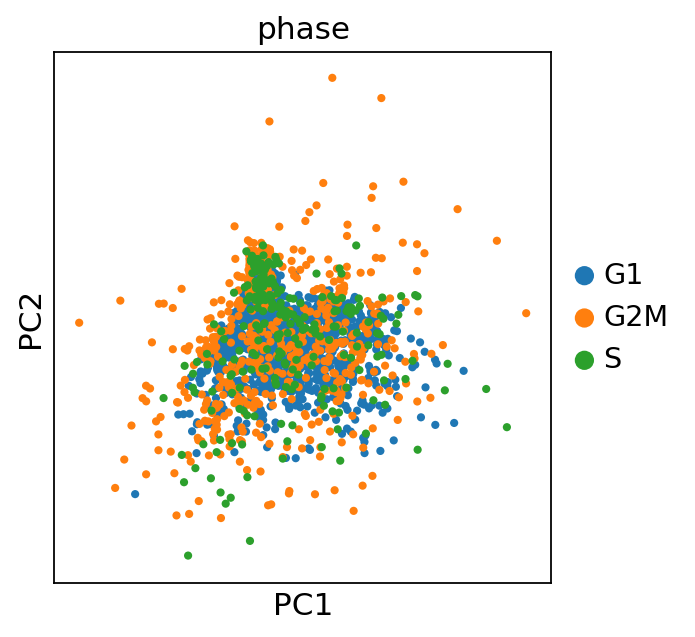

In [26]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [27]:
adata.X.max()

6.2120047

In [28]:
adata.X

array([[-2.4638599e-04, -9.9401362e-04, -3.5539787e-02, ...,
        -5.5381977e-03, -2.5888722e-02, -1.3170534e-04],
       [-3.1455976e-04, -9.5940352e-04, -3.8360197e-02, ...,
        -7.0201401e-03, -2.7928747e-02, -1.8119688e-05],
       [-2.3972745e-04, -9.9585077e-04, -3.4782607e-02, ...,
        -5.6915549e-03, -2.6685249e-02, -1.2865248e-04],
       ...,
       [-3.5696992e-04, -9.4456185e-04, -4.2202607e-02, ...,
        -6.6499989e-03, -2.4881853e-02, -8.7754124e-06],
       [-2.3803883e-04, -9.9753588e-04, -3.4971163e-02, ...,
        -5.4949340e-03, -2.6100537e-02, -1.3905492e-04],
       [-3.6229787e-04, -9.4163552e-04, -4.2353906e-02, ...,
        -6.8085915e-03, -2.5184173e-02,  2.1315448e-06]], dtype=float32)

In [29]:
import time
import phenograph
from sklearn.manifold import TSNE
%matplotlib inline

In [30]:
matrix = adata.X

In [31]:
current = time.time()
communities, graph, Q = phenograph.cluster(matrix, n_jobs=12, k=100, primary_metric='euclidean')
end = time.time()
diff = end - current

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 27.26048231124878 seconds
Jaccard graph constructed in 1.9796767234802246 seconds
Wrote graph to binary file in 0.6632192134857178 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.665424
Louvain completed 21 runs in 2.1456799507141113 seconds
PhenoGraph complete in 32.214383602142334 seconds


In [32]:
from collections import Counter

In [33]:
Counter(communities)

Counter({0: 942, 1: 400, 2: 319, 3: 268, 4: 160, 5: 127})

In [30]:
Counter(communities)

Counter({0: 392,
         1: 362,
         2: 329,
         3: 226,
         4: 222,
         5: 208,
         6: 205,
         7: 141,
         8: 131})

In [34]:
arr = graph.toarray()
arr_full = arr+arr.T
np.fill_diagonal(arr_full, 1)
dist = (arr_full- arr_full.max())*(-1)
np.fill_diagonal(dist, 0)
tsne = TSNE(n_components=2, perplexity= 70,metric='precomputed').fit_transform(dist)


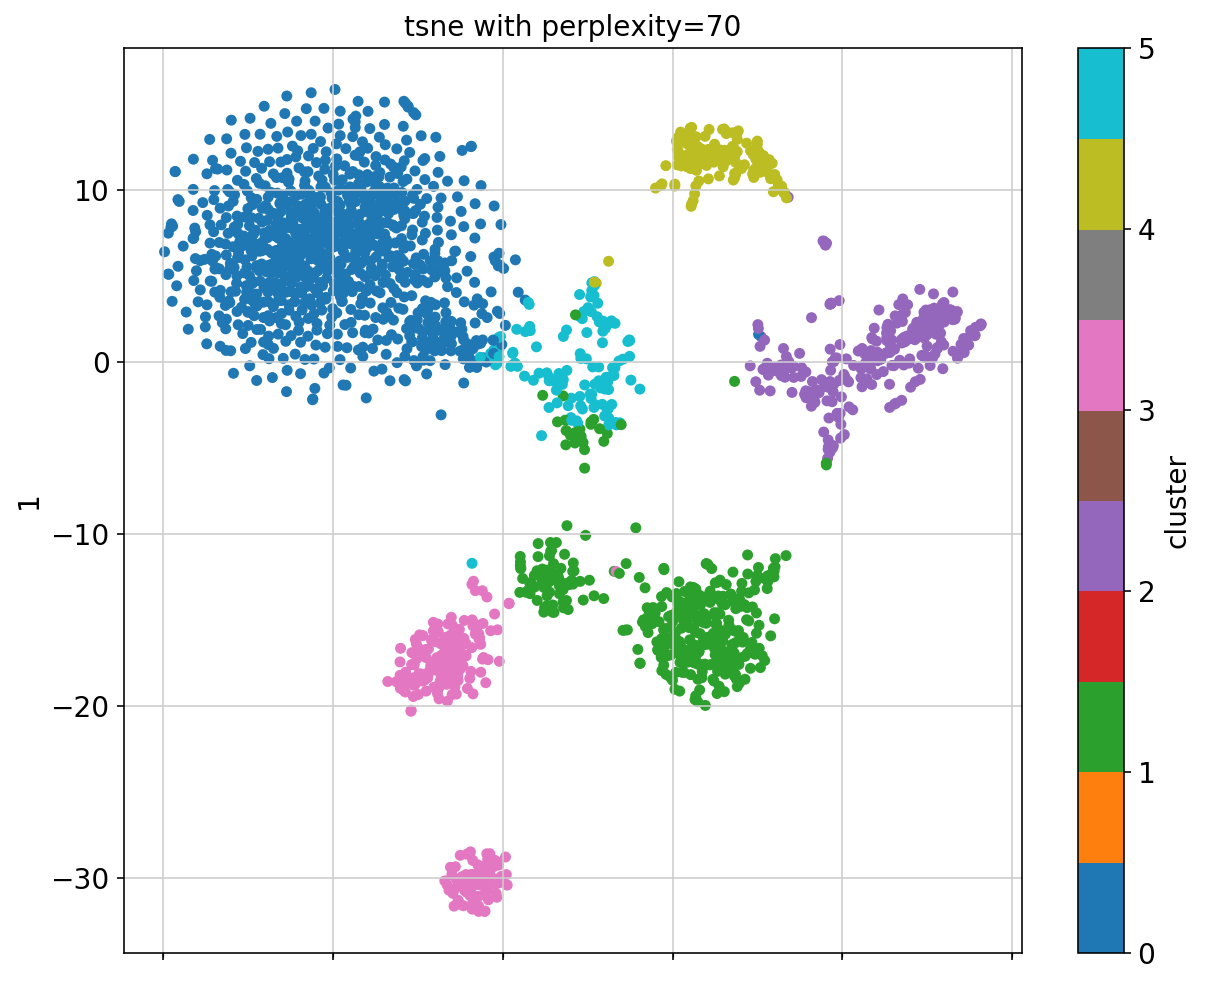

In [35]:

df_tsne = pd.DataFrame(tsne)
df_tsne['cluster'] = communities
#df_tsne['ground_truth'] = cell_groups
#df_tsne['ground_truth'] = df_tsne['ground_truth'].apply(lambda x: int(str(x, 'utf-8')[-1]))
df_tsne.plot(kind='scatter', x=0, y=1, c='cluster', figsize=(10,8),colormap='tab10', grid=True, title='tsne with perplexity=70')

## Alternative workflow
### Selecting 1000 genes by dispersion

In [36]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)

In [37]:
current = time.time()
communities, graph, Q = phenograph.cluster(matrix, n_jobs=12, k=100, primary_metric='euclidean')
end = time.time()
diff = end - current

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 25.82263445854187 seconds
Jaccard graph constructed in 2.3456215858459473 seconds
Wrote graph to binary file in 1.198561191558838 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.6653
Louvain completed 21 runs in 3.991828441619873 seconds
PhenoGraph complete in 33.54535746574402 seconds


In [38]:
Counter(communities)

Counter({0: 942, 1: 391, 2: 320, 3: 269, 4: 160, 5: 134})

In [51]:
Counter(communities)

Counter({0: 339,
         1: 328,
         2: 306,
         3: 226,
         4: 215,
         5: 191,
         6: 187,
         7: 150,
         8: 141,
         9: 133})

In [39]:
arr = graph.toarray()
arr_full = arr+arr.T
np.fill_diagonal(arr_full, 1)
dist = (arr_full- arr_full.max())*(-1)
np.fill_diagonal(dist, 0)
tsne = TSNE(n_components=2, perplexity= 70,metric='precomputed').fit_transform(dist)


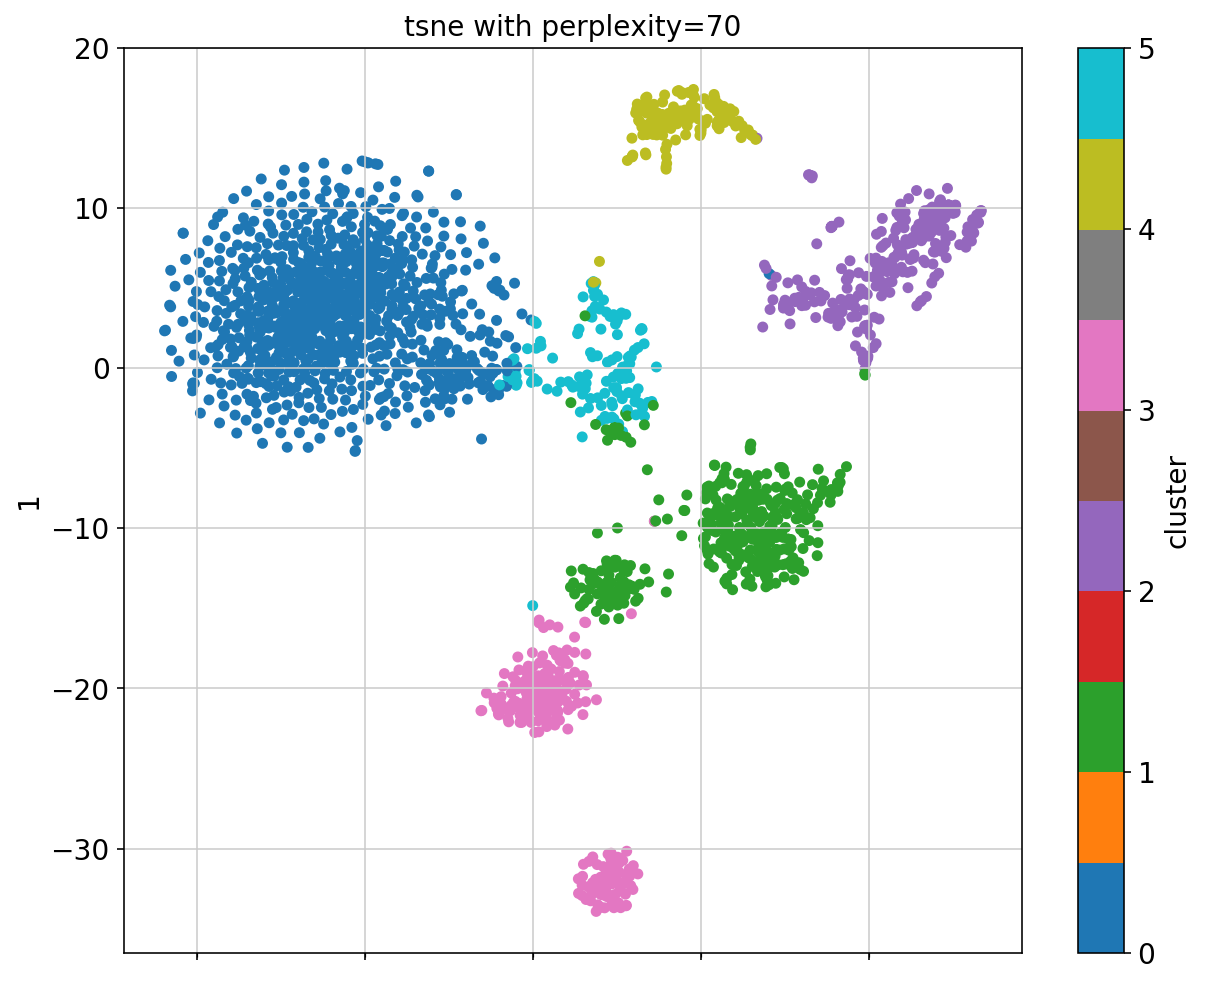

In [40]:

df_tsne = pd.DataFrame(tsne)
df_tsne['cluster'] = communities
#df_tsne['ground_truth'] = cell_groups
#df_tsne['ground_truth'] = df_tsne['ground_truth'].apply(lambda x: int(str(x, 'utf-8')[-1]))
df_tsne.plot(kind='scatter', x=0, y=1, c='cluster', figsize=(10,8),colormap='tab10', grid=True, title='tsne with perplexity=70')

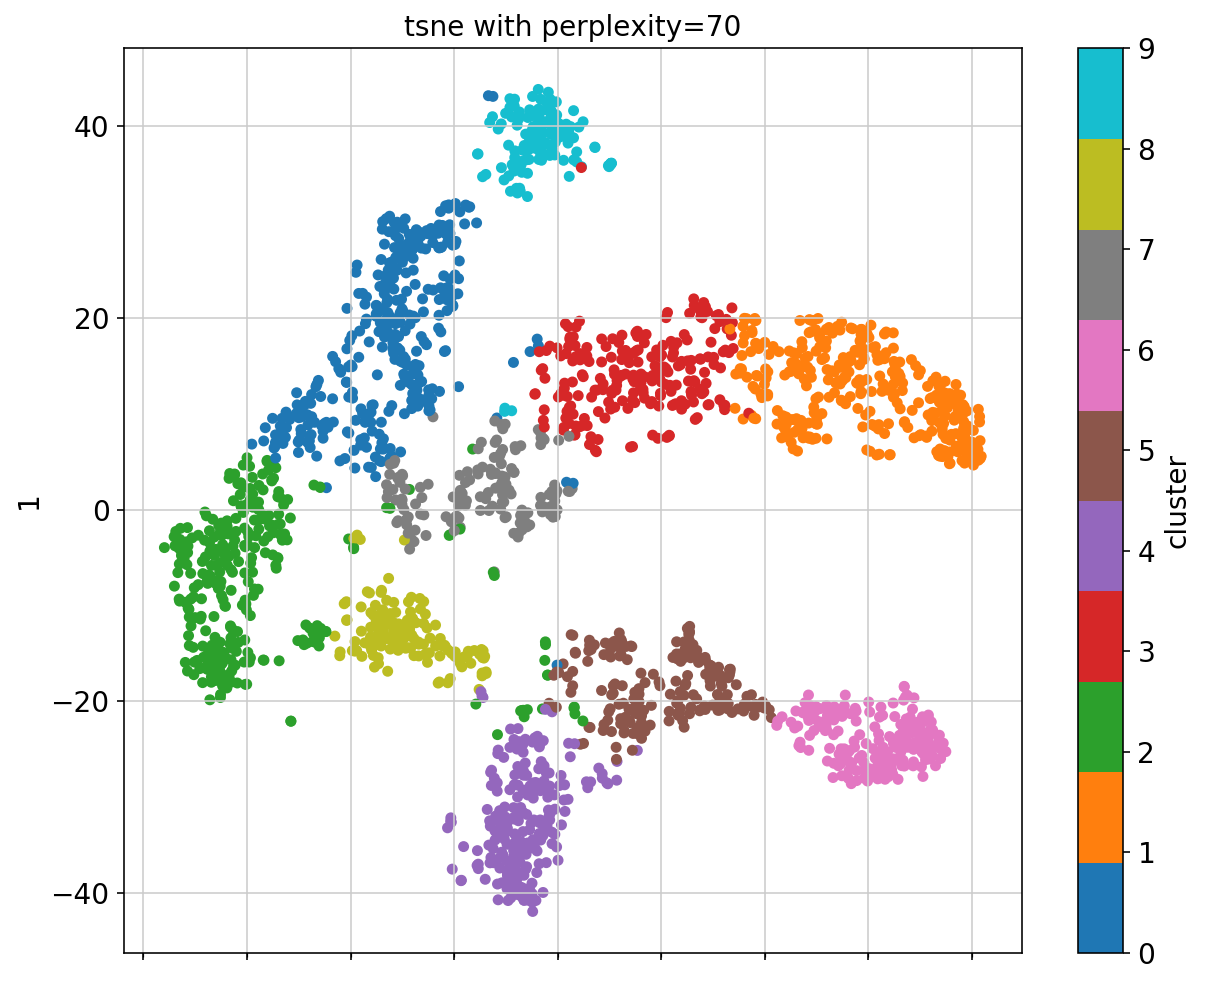

In [57]:

df_tsne = pd.DataFrame(tsne)
df_tsne['cluster'] = communities
#df_tsne['ground_truth'] = cell_groups
#df_tsne['ground_truth'] = df_tsne['ground_truth'].apply(lambda x: int(str(x, 'utf-8')[-1]))
df_tsne.plot(kind='scatter', x=0, y=1, c='cluster', figsize=(10,8),colormap='tab10', grid=True, title='tsne with perplexity=70')